# Testing correlation computation

Since we are using an alternative method to compute fourier transform (regression), we need to check if the correlation of the signals works correctly. Remembering that correlation means linear filter, and lineal filter means matched filter, so we need a correlation that gives as result an unormalized Signal-to-Noise Ratio, and this means, the time offet necessary to match a given template to a unknown signal. Here we test:

* test 1: veracity of data transform
* test 2: veracity of template transform
* test 3: veracity of correlation
* test 4: veracity of time offset and match.

In this case we will use a composition of sinusoidal signals, and the data will have gaussian noise with standard deviation of 1. We alse configure the regressor to give an score R2 close to 1 (overfit) for this kind of signal.

In [1]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../../")
from mfilter.regressions import * #regression objects
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples # samples objects
from mfilter.transform.transform import FourierTransform, Regression, FFT # transform objects

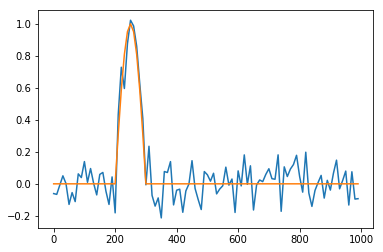

In [2]:
# global variables

# regressor
reg = SGDRegression(alpha=1e-4, max_iter=1000, penalty="elasticnet", l1_ratio=1, tol=0.001)

# data, composition of three frequencies, not necessary satisfying nyquist limit
f1 = 0.005
f2 = 0.01
f3 = 0.03

# time, regular sampled, with sampling rate equal to the lower frequency.
fs = 0.05*2
N = 100
times = TimesSamples(np.arange(N) / fs)

# sine signals
sin1 = np.zeros(len(times))
L = 20
R = 30
sin1[L:R] = np.sin(2 * np.pi * f1 * times[0:R-L])
# sin2 = np.sin(2 * np.pi * f2 * times)
# sin3 = np.zeros(len(times))
# sin3[L:R] = np.sin(2 * np.pi * f3 * times[0:R-L])

# compose data
fff = 1
noise = np.random.normal(0, 0.1, N)
data = TimeSeries(noise+sin1, times=times)


# compose template
template = TimeSeries(sin1, times=times)

# sonce both start sines at same time, the time offset of match should be 0
teo_time_offset = 0

plt.plot(times, data)
plt.plot(times, template)

### Test 1:

Perfomr fourier transform of the data, and check that the four frequencies are presents, also check R2 score

R2 score:  0.9898391820717697


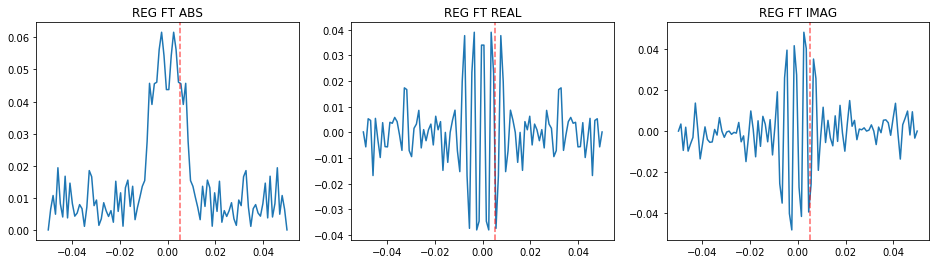

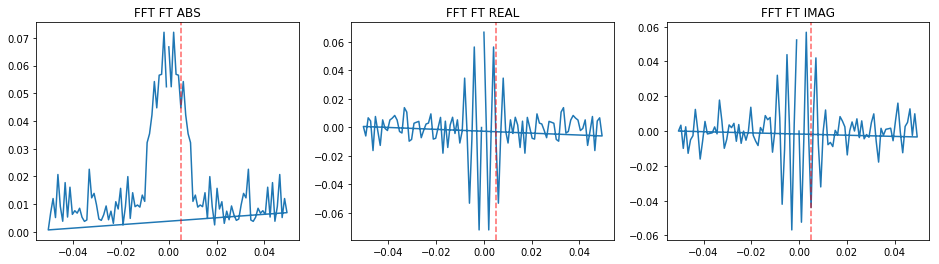

In [3]:
def grid_t1(times):
    df = 1/times.duration
    return FrequencySamples(input_time=times, maximum_frequency=fs/2, minimum_frequency=-fs/2, 
                            samples_per_peak=1)

def reg_transform_t1(times, data):
    grid = grid_t1(times)
    tr = Regression(reg=reg,freq=grid)
    return data.to_frequencyseries(tr), tr.get_frequency(), tr

def fft_transform_at1(times, data):
    tr = FFT(times)
    return data.to_frequencyseries(tr), tr.get_frequency(N=len(times)), tr

def t1(times, data):
    ft1, freqs1, _ = reg_transform_t1(times, data)
    print("R2 score: ", reg.score(data))
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 4))
    ax1.plot(freqs1, abs(ft1), '-')
    ax2.plot(freqs1, np.real(ft1), '-')
    ax3.plot(freqs1, np.imag(ft1), '-')
    ax1.set_title("REG FT ABS")
    ax2.set_title("REG FT REAL")
    ax3.set_title("REG FT IMAG")
    
    for ax in [ax1, ax2, ax3]:
        ax.axvline(f1, color="r", linestyle="--", alpha=0.6)
#         ax.axvline(f2, color="r", linestyle="--", alpha=0.6)
#         ax.axvline(f3, color="r", linestyle="--", alpha=0.6)
    
    ft2, freqs2, _ = fft_transform_at1(times, data)
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 4))
    ax1.plot(freqs2, abs(ft2)/N, '-')
    ax2.plot(freqs2, np.real(ft2)/N, '-')
    ax3.plot(freqs2, np.imag(ft2)/N, '-')
    ax1.set_title("FFT FT ABS")
    ax2.set_title("FFT FT REAL")
    ax3.set_title("FFT FT IMAG")
    for ax in [ax1, ax2, ax3]:
        ax.axvline(f1, color="r", linestyle="--", alpha=0.6)
#         ax.axvline(f2, color="r", linestyle="--", alpha=0.6)
#         ax.axvline(f3, color="r", linestyle="--", alpha=0.6)


# df = 1/times.duration
# print("range frequency using M=N is: ", N * df)
# # so we need to use a higher df
# print("we need a range of at least: ", f4 - f1)
# print("so we multiply df by 10")
# df *= 10
# print("now, max range is: ", N * df)
# freqs = np.arange(N) * df + f1 - 2 * df
# print("max freq is: ", freqs[-1], "and min is: ", freqs[0])
t1(times, data)


#### Analysis

We observe that the first 2 frequencies are correctly found in both methods (REG and FFT), but the third frequency is lost, if we use 4 frequencies, the third it apears but the four it's lost, so this is probably a problem of the method and not of the implementation, and since the same happens on both (REG and FFT) we can say that this behavior usualy happens and it probabily has to be with the nyquist limit and the sampling rate (the third frequency is closes to nyquist limit)

Regrardless of all these observations, the R2 score is good and the regression match with the FFT so we can continue and use this result.

An important observation is that in Regression method the real part is inverted compared to FFT method, same happens with imaginary part.

### Test 2:

We repeat the same for the template signal

R2 score:  0.9921811406310067


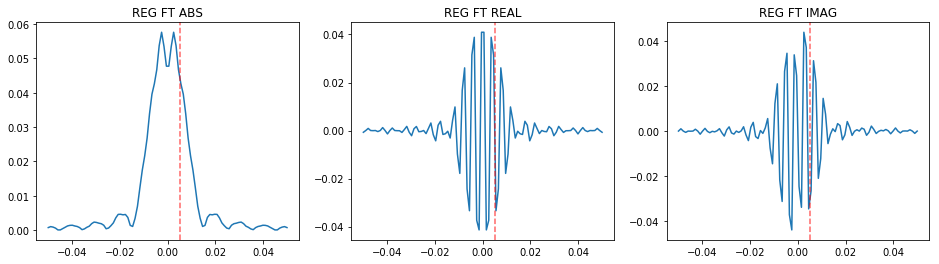

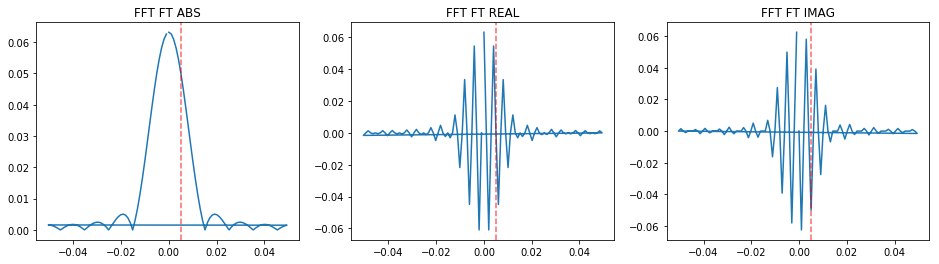

In [4]:
t1(times, template)

#### Analysis

Here we see that result given by Regression are very different from results given by FFT method, specialy in real and imaginary part. In this case FFT set real part to almost 0 and imaginary part conserve all the relevant information, i the other hand, regression give similar information for both parts, real and imaginary.

### Test 3:

Finnally, we test the correlation, and the form it gives, remembering, linear filter and correlatin are related by:

$$ (x | h) = [x(t) * h(-t)](\tau) =  \int X(f) H^{*}(f) e^{2 \pi f \tau} df$$


We also check that the implemented methods works as expected comparing to the result given by apply the method part by part.


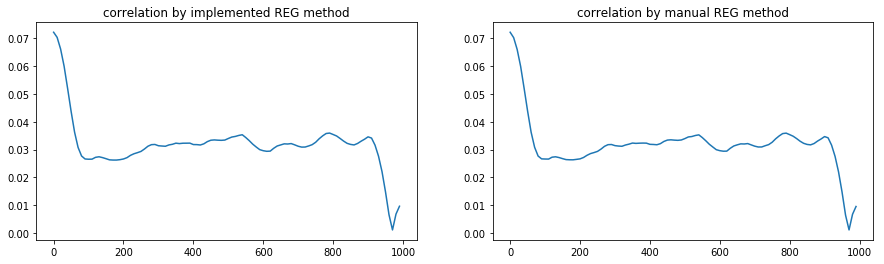

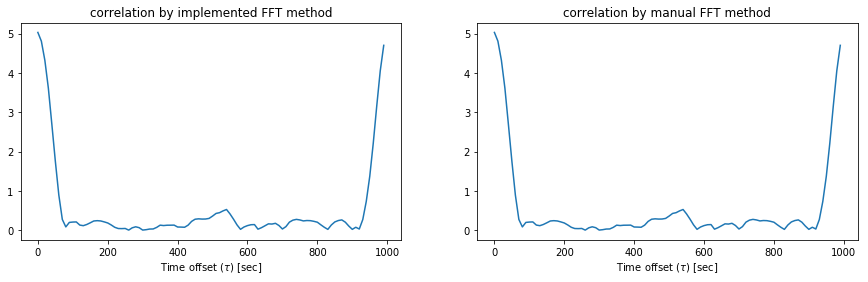

In [19]:
def cast_into_ft(coefs):
    n_freqs = int(len(coefs) / 2)
    ft = 1j * np.zeros(n_freqs)
    for i in range(n_freqs):
        ft[i] = coefs[i] - 1j * coefs[i + n_freqs]
    return ft


def split_ft(ft):
    coefs = np.zeros(len(ft)*2)
    for i in range(len(ft)):
        coefs[i] = ft[i].real
        coefs[i + len(ft)] = -ft[i].imag
    return coefs

def reset(reg):
    reg.coef_ = None
    

def new_dict(times, freqs):
    m = times.reshape(-1, 1) * freqs
    m = np.exp(2j * np.pi * m)
    return np.hstack((m.real, m.imag))

def grid_t3(times):
    df = 1/times.duration
    return FrequencySamples(input_time=times, maximum_frequency=fs/2, minimum_frequency=-fs/2, 
                            samples_per_peak=1)

def t3(times, data, template):
    
    # implemented method REG
    ft1d, freqs1, tr1d = reg_transform_t1(times, data)
    ft1t, freqs2, tr1t = reg_transform_t1(times, template)
    if freqs1 != freqs2:
        print("REG fail")
        return False
    corr = ft1d
    corr *= ft1t.conj()
    snr = corr.to_timeseries(tr1d)
    
    # by parts REG
    regb = reg._reg
    freqs = grid_t3(times)
    X = new_dict(times.value, freqs.value)
    reset(regb)
    regb.fit(X, data)
    ft1db = cast_into_ft(regb.coef_)
    reset(regb)
    regb.fit(X, template)
    ft1tb = cast_into_ft(regb.coef_)
    reset(regb)
    corrb = ft1db * ft1tb.conj()
    regb.coef_ = split_ft(corrb)
    snrb = regb.predict(X)
    
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 4))
    ax1.set_title("correlation by implemented REG method")
    ax2.set_title("correlation by manual REG method")
    ax1.plot(times, abs(snr))
    ax2.plot(times, abs(snrb))
    
    
    # implemented method FFT
    ft2d, freqs2, tr2d = fft_transform_at1(times, data)
    ft2t, freqs2, tr2t = fft_transform_at1(times, template)
#     if freqs1 != freqs2:
#         print("FFT fail")
#         return False
    
    corr2 = FrequencySeries(ft2d.value * ft2t.conj(), frequency_grid=freqs2, epoch=ft2d.epoch)
    
    snr2 = corr2.to_timeseries(tr2d)
    
    # by parts FFT
    fftd = np.fft.fft(data)
    fftt = np.fft.fft(template)
    corr2b = fftd * fftt.conjugate()
    fftsnr = np.fft.ifft(corr2b)
    
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 4))
    ax1.set_title("correlation by implemented FFT method")
    ax2.set_title("correlation by manual FFT method")
    ax1.set_xlabel(r'Time offset ($\tau$) [sec]')
    ax2.set_xlabel(r'Time offset ($\tau$) [sec]')
    ax1.plot(times, abs(snr2))
    ax2.plot(times, abs(fftsnr))
    
    
    
    
t3(times, data, template)

#### Analysis

As expected the time offset ($\tau$) optimal for the match results to be 0, since both, data and template were generated with the peak at same time. We also check that implemented methods works well since they match with calculating the correlation part by part.